In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from causalml.inference.tree import UpliftRandomForestClassifier
import os 

C:\Users\tsterk\AppData\Local\anaconda3\envs\causalml_py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


In [2]:
import pandas as pd
import warnings

pd.options.mode.chained_assignment = None
warnings.simplefilter("ignore")

In [3]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != "Thesis code" and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT))

from Functions.data_utils import (
    plot_incremental_response_rate,
    uplift_by_decile_bin,
    coerce_metrics_to_numeric,
)

In [4]:
import pandas as pd

file_path = r"Data/covariates_modeling_uplift_models_2026-02-28.csv"
df = pd.read_csv(file_path)


In [5]:
df['cameback'].value_counts()

cameback
0    264346
1      3321
Name: count, dtype: int64

In [6]:
treatment_converter = {
    "BNLX_ChurnP_10_test_export.csv": "treatment_1",
    "BNLX_ChurnP_10_controle_export.csv": "control_1", 
    
    "BNLX_ChurnP_25_test_export.csv": "treatment_2",
    "BNLX_ChurnP_25_controle_export.csv": "control_2",

    "BNLX_ChurnP_5eu_test_export.csv": "treatment_3",
    "BNLX_ChurnP_5eu_controle_export.csv": "control_3",

    "BNLX_ChurnP_10eu_test_export.csv": "treatment_4",
    "BNLX_ChurnP_10eu_controle_export.csv": "control_4",
    
    "BNLX_ChurnP_250_test_export.csv": "treatment_5",
    "BNLX_ChurnP_250_controle_export.csv": "control_5",

    "BNLX_ChurnP_500_test_export.csv": "treatment_6",
    "BNLX_ChurnP_500_controle_export.csv": "control_6",    
    
    # "BNLX_ChurnP_SKUd_test_export.csv": "treatment_7",
    # "BNLX_ChurnP_SKUd_controle_export.csv": "control_7",

    "BNLX_ChurnP_SKUe_test_export.csv": "treatment_8",
    "BNLX_ChurnP_SKUe_controle_export.csv": "control_8",    
    
    "BNLX_ChurnP_niks_test_export.csv": "treatment_9",
    "BNLX_ChurnP_niks_controle_export.csv": "control_9",
}

df["treatment"] = df["treatment_indicator"].map(treatment_converter)
df = df[df["treatment"].notna()]
df['treatment'].unique()


<StringArray>
['treatment_6',   'control_6',   'control_9',   'control_4',   'control_1',
   'control_3', 'treatment_2',   'control_5', 'treatment_4', 'treatment_5',
 'treatment_8', 'treatment_9', 'treatment_1',   'control_2', 'treatment_3',
   'control_8']
Length: 16, dtype: str

In [7]:
categorical_cols  = ['has_rfl','gender','country_sk']
numeric_cols = [ 'recency', 'frequency', 'monetary_value',  'total_volume', 'length_of_relationship', 'online_sales', 'retail_sales', 
      'food_total', 'vhms_total', 'sports_total', 'beauty_total', 'frequency_52wk', 'monetary_value_52wk', 'volume_52wk', 'online_sales_52w', 
       'retail_sales_52w', 'frequency_53w_104w', 'monetary_value_53w_104w', 'volume_53w_104w', 'online_sales_53w_104w','retail_sales_53w_104w']

In [8]:
df = coerce_metrics_to_numeric(df, numeric_cols)

df[categorical_cols] = df[categorical_cols].astype("object")
df[numeric_cols] = df[numeric_cols].astype("int64")


In [9]:
(100 * df.groupby('treatment_indicator')['cameback'].mean()).round(2)


treatment_indicator
BNLX_ChurnP_10_controle_export.csv      1.08
BNLX_ChurnP_10_test_export.csv          1.25
BNLX_ChurnP_10eu_controle_export.csv    1.25
BNLX_ChurnP_10eu_test_export.csv        1.45
BNLX_ChurnP_250_controle_export.csv     1.13
BNLX_ChurnP_250_test_export.csv         1.46
BNLX_ChurnP_25_controle_export.csv      1.13
BNLX_ChurnP_25_test_export.csv          1.24
BNLX_ChurnP_500_controle_export.csv     1.27
BNLX_ChurnP_500_test_export.csv         1.53
BNLX_ChurnP_5eu_controle_export.csv     1.08
BNLX_ChurnP_5eu_test_export.csv         1.37
BNLX_ChurnP_SKUe_controle_export.csv    1.17
BNLX_ChurnP_SKUe_test_export.csv        1.25
BNLX_ChurnP_niks_controle_export.csv    1.15
BNLX_ChurnP_niks_test_export.csv        1.24
Name: cameback, dtype: float64

In [10]:
X = df[numeric_cols + categorical_cols]
y = df['cameback']
t = df['treatment']

In [11]:
def train_full_RF_uplift_store(
    df_train: pd.DataFrame,
    X_train: pd.DataFrame,
    y_train,
    t_train,
    *,
    random_state: int = 42,
    control_name: str = "control_0",
) -> dict:
    """Train on full data and return model artifacts for later inference."""
    y_s = pd.Series(y_train, index=X_train.index)
    t_s = pd.Series(t_train, index=X_train.index)

    categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns
    numeric_cols = X_train.columns.difference(categorical_cols)

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

    def _prep_cat(X_part: pd.DataFrame) -> pd.DataFrame:
        if len(categorical_cols) == 0:
            return X_part
        return X_part.assign(
            **{c: X_part[c].astype("string").fillna("MISSING") for c in categorical_cols}
        )

    def encode_X(X_part: pd.DataFrame) -> np.ndarray:
        X_part = _prep_cat(X_part)
        X_num = X_part[numeric_cols].to_numpy()
        if len(categorical_cols) == 0:
            return X_num
        X_cat = ohe.transform(X_part[categorical_cols])
        return np.hstack([X_num, X_cat])

    X_train_prep = _prep_cat(X_train)
    if len(categorical_cols) > 0:
        ohe.fit(X_train_prep[categorical_cols])

    X_train_enc = encode_X(X_train)

    uplift_model = UpliftRandomForestClassifier(control_name=control_name, n_estimators= 100, random_state=random_state)
    uplift_model.fit(
        X_train_enc,
        treatment=t_s.astype(str).values,
        y=y_s.astype(int).values,
    )

    return {
        "model": uplift_model,
        "ohe": ohe,
        "categorical_cols": categorical_cols,
        "numeric_cols": numeric_cols,
        "control_name": control_name,
    }


# Train and store all 9 experiment models
trained_models: dict[int, dict] = {}

for k in range(1, 10):
    mask = t.isin([f"treatment_{k}", f"control_{k}"])
    if not mask.any():
        continue
    trained_models[k] = train_full_RF_uplift_store(
        df_train=df.loc[mask],
        X_train=X.loc[mask],
        y_train=y.loc[mask],
        t_train=t.loc[mask],
        control_name=f"control_{k}",
    )
    print(f"Trained model for experiment {k}")

Trained model for experiment 1
Trained model for experiment 2
Trained model for experiment 3
Trained model for experiment 4
Trained model for experiment 5
Trained model for experiment 6
Trained model for experiment 8
Trained model for experiment 9


## Deployement dataset

In [33]:
active_treatments = [1, 2, 3, 4, 5, 6, 8, 9]  # 7 is skipped

file_path_2 = r"Data/covariates_deployment_dataset_2026-02-28.csv"
df_half_2 = pd.read_csv(file_path_2)
df_half_2_shuffled = df_half_2.sample(frac=0.5, random_state=42)
n = len(df_half_2_shuffled)
chunk = n // 8

experiment_samples = {
    t: df_half_2_shuffled.iloc[i*chunk : (i+1)*chunk]
    for i, t in enumerate(active_treatments)
}

print({k: len(v) for k, v in experiment_samples.items()})

{1: 16658, 2: 16658, 3: 16658, 4: 16658, 5: 16658, 6: 16658, 8: 16658, 9: 16658}


In [34]:
for k, df_k in experiment_samples.items():
    experiment_samples[k] = coerce_metrics_to_numeric(df_k, numeric_cols)
    experiment_samples[k][categorical_cols] = experiment_samples[k][categorical_cols].astype("object")
    experiment_samples[k][numeric_cols] = experiment_samples[k][numeric_cols].astype("int64")

In [35]:
def predict_uplift(
    artifacts: dict,
    df_test: pd.DataFrame,
    X_test: pd.DataFrame,
) -> pd.DataFrame:
    ohe = artifacts["ohe"]
    categorical_cols = artifacts["categorical_cols"]
    numeric_cols = artifacts["numeric_cols"]

    def _prep_cat(X_part: pd.DataFrame) -> pd.DataFrame:
        if len(categorical_cols) == 0:
            return X_part
        return X_part.assign(
            **{c: X_part[c].astype("string").fillna("MISSING") for c in categorical_cols}
        )

    def encode_X(X_part: pd.DataFrame) -> np.ndarray:
        X_part = _prep_cat(X_part)
        X_num = X_part[numeric_cols].to_numpy()
        if len(categorical_cols) == 0:
            return X_num
        X_cat = ohe.transform(X_part[categorical_cols])
        return np.hstack([X_num, X_cat])

    X_test_enc = encode_X(X_test)

    uplift_pred = np.asarray(artifacts["model"].predict(X_test_enc))
    cate = uplift_pred if uplift_pred.ndim == 1 else uplift_pred.max(axis=1)

    result_df = df_test.loc[X_test.index].copy()
    result_df["cate"] = cate
    return result_df


feature_cols = numeric_cols + categorical_cols

full_test_df = pd.concat(
    [
        predict_uplift(
            artifacts=trained_models[k],
            df_test=experiment_samples[k],
            X_test=experiment_samples[k][feature_cols],
        ).assign(experiment_k=k)
        for k in trained_models
    ],
    axis=0,
).sort_values(["experiment_k", "cate"], ascending=[True, False])

full_test_df.head()

,customer_nk,has_rfl,gender,country_sk,recency,frequency,monetary_value,total_volume,length_of_relationship,online_sales,...,volume_52wk,online_sales_52w,retail_sales_52w,frequency_53w_104w,monetary_value_53w_104w,volume_53w_104w,online_sales_53w_104w,retail_sales_53w_104w,cate,experiment_k
79580,2c7e4890-96bb-497c-8e6a-b5991fb0076e,1,F,hbi|eu|nl,501,16,948,189,1767,632,...,25,120,0,4,291,62,181,109,0.053015,1
241416,e1be4d13-5599-48c0-a17b-aea9f84d0efe,1,F,hbi|eu|nl,521,29,786,201,1525,775,...,53,258,11,7,185,65,185,0,0.052335,1
48125,3dde7816-b59c-483c-b2e7-52abb7f06ac3,1,F,hbi|eu|nl,642,11,571,138,1803,522,...,34,210,0,2,89,17,89,0,0.051333,1
42540,2e652c45-8001-4089-b280-a64ff2367535,1,F,hbi|eu|nl,420,24,1063,186,1779,838,...,24,101,47,3,84,15,74,10,0.049468,1
12924,9a17394d-18b7-4a13-9f9f-4f32291152ce,1,F,hbi|eu|nl,388,12,666,170,1736,614,...,42,151,0,2,140,15,140,0,0.048927,1


In [36]:
# Reverse lookup: map experiment_k back to the original test filename
k_to_filename = {
    1: "BNLX_ChurnP_10_test_export.csv",
    2: "BNLX_ChurnP_25_test_export.csv",
    3: "BNLX_ChurnP_5eu_test_export.csv",
    4: "BNLX_ChurnP_10eu_test_export.csv",
    5: "BNLX_ChurnP_250_test_export.csv",
    6: "BNLX_ChurnP_500_test_export.csv",
    7: "BNLX_ChurnP_SKUd_test_export.csv",
    8: "BNLX_ChurnP_SKUe_test_export.csv",
    9: "BNLX_ChurnP_niks_test_export.csv",
}

full_test_df["original_incentive_name"] = full_test_df["experiment_k"].map(k_to_filename)

In [37]:
top30_per_treatment = (
    full_test_df
    .groupby("experiment_k", group_keys=False)
    .apply(lambda g: g.nlargest(int(len(g) * 0.30), "cate"))
    .reset_index(drop=True)
)

In [38]:
test_selected_binary_uplift = []
control_selected_binary_uplift = []

for k in sorted(top30_per_treatment["original_incentive_name"].unique()):
    group = top30_per_treatment[top30_per_treatment["original_incentive_name"] == k].reset_index(drop=True)
    test_selected_binary_uplift.append(group.iloc[0::2])   # rows 0, 2, 4, ... (odd positions)
    control_selected_binary_uplift.append(group.iloc[1::2]) # rows 1, 3, 5, ... (even positions)

test_selected_binary_uplift = pd.concat(test_selected_binary_uplift).reset_index(drop=True)
control_selected_binary_uplift = pd.concat(control_selected_binary_uplift).reset_index(drop=True)

In [39]:
# Create output folder
os.makedirs("Input_phase_2", exist_ok=True)

# --- Treatment file ---
treatment_output = test_selected_binary_uplift[["customer_nk", "original_incentive_name"]].copy()
treatment_output.to_csv("Input_phase_2/treatment_selected_binary.csv", index=False)

# --- Control file ---
control_output = control_selected_binary_uplift[["customer_nk", "original_incentive_name"]].copy()
control_output["original_incentive_name"] = "Control"
control_output.to_csv("Input_phase_2/control_selected_binary.csv", index=False)

print(f"Treatment rows: {len(treatment_output)}")
print(f"Control rows:   {len(control_output)}")

Treatment rows: 19992
Control rows:   19984


### Sanity check preds

In [40]:
test_selected_binary_uplift['original_incentive_name'].value_counts()

original_incentive_name
BNLX_ChurnP_10_test_export.csv      2499
BNLX_ChurnP_10eu_test_export.csv    2499
BNLX_ChurnP_250_test_export.csv     2499
BNLX_ChurnP_25_test_export.csv      2499
BNLX_ChurnP_500_test_export.csv     2499
BNLX_ChurnP_5eu_test_export.csv     2499
BNLX_ChurnP_SKUe_test_export.csv    2499
BNLX_ChurnP_niks_test_export.csv    2499
Name: count, dtype: int64

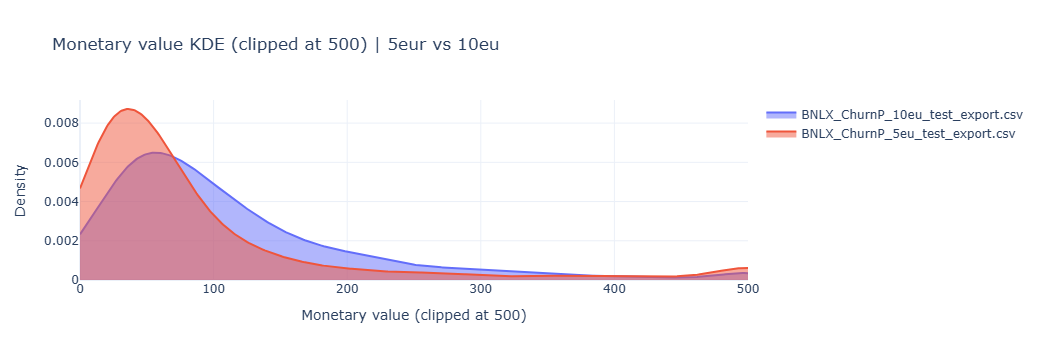

In [41]:
# Sanity check pattern we expec tto see 5eu lower better, 10eu higher better!
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

def plot_monetary_value_kde_top30(predicted_top30_per_treatment, clip_max=500):
    incentives = ["BNLX_ChurnP_5eu_test_export.csv", "BNLX_ChurnP_10eu_test_export.csv"]

    df_plot = predicted_top30_per_treatment.loc[
        predicted_top30_per_treatment["original_incentive_name"].isin(incentives),
        ["original_incentive_name", "monetary_value"]
    ].dropna(subset=["monetary_value"]).copy()

    df_plot["monetary_value"] = df_plot["monetary_value"].clip(upper=clip_max)

    x_grid = np.linspace(0, clip_max, 500)

    fig = go.Figure()

    for name, group in df_plot.groupby("original_incentive_name"):
        values = group["monetary_value"].values

        if len(values) < 2:
            continue

        kde = gaussian_kde(values)
        density = kde(x_grid)

        fig.add_trace(
            go.Scatter(
                x=x_grid,
                y=density,
                mode="lines",
                fill="tozeroy",
                name=name
            )
        )

    fig.update_layout(
        title=f"Monetary value KDE (clipped at {clip_max}) | 5eur vs 10eu",
        xaxis_title=f"Monetary value (clipped at {clip_max})",
        yaxis_title="Density",
        template="plotly_white"
    )

    fig.update_xaxes(range=[0, clip_max])

    fig.show()

plot_monetary_value_kde_top30(test_selected_binary_uplift, clip_max=500)